# Lake model continued - sensitivity analysis

In the previous week you used the lake problem as a means of getting acquainted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of the [open exploration tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the separate anthropogenic release decision**

There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis.

## 1. SOBOL
1. Apply Sobol with 3 separate release policies (0, 0.05, and 0.1) and analyse the results for each release policy separately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each separate release policy and apply sobol to each of the three separate release policies. If this sounds too complicated, just do it on each release policy separately.*

In [4]:
from ema_workbench import Samplers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome, SequentialEvaluator
from scipy.integrate import odeint


In [20]:
from lakemodel_function import lake_problem

# Instantiate the model
model = Model('lake', function=lake_problem)
time_horizon = 100

# Specify uncertainties  # Dit is dus een vijf dimensionele space van uncertainties. Met voor elke dimensie een min en max waarde zeg maar.
model.uncertainties = [RealParameter('mean',0.01,0.05), RealParameter('stdev',0.001,0.005),
                       RealParameter('b',0.1,0.45), RealParameter('q',2,4.5),
                       RealParameter('delta',0.93,0.99)]

# Set levers, one for each time step    # Dit is dus een 100 dimensionele space van uncertainties. Met voor elke dimensie dezelfde min en max waarde.
# Dit geeft aan hoeveel schadelijke vloeistof elke tijdstip gedumpt mag worden in de rivier als beleid. Hier kan mee geëxperimenteerd worden.
levers = []
for i in range(time_horizon):
    lever = RealParameter(f'l{i}',0.05,0.1)
    levers.append(lever)
#print(levers)
model.levers = levers

# Specify outcomes
model.outcomes = [ScalarOutcome('max_P'), ScalarOutcome('utility'),
                  ScalarOutcome('inertia'), ScalarOutcome('reliability')]


#Waarom is dit Scalar en geen Time Series?

In [9]:
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with SequentialEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes["reliability"], calc_second_order=True, print_to_console=False)

100%|███████████████████████████████████| 12000/12000 [01:05<00:00, 183.79it/s]


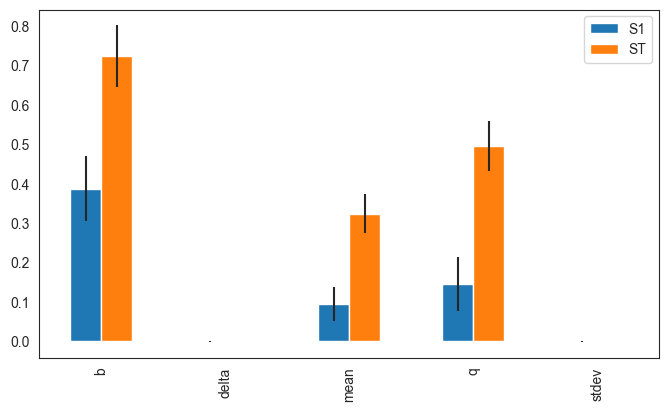

In [11]:
import pandas as pd
import seaborn as sns

cores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [13]:
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with SequentialEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes["reliability"], calc_second_order=True, print_to_console=False)

C:\Users\thoma\Anaconda3\envs\model_based_decision_making\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
100%|███████████████████████████████████| 12000/12000 [00:56<00:00, 212.19it/s]


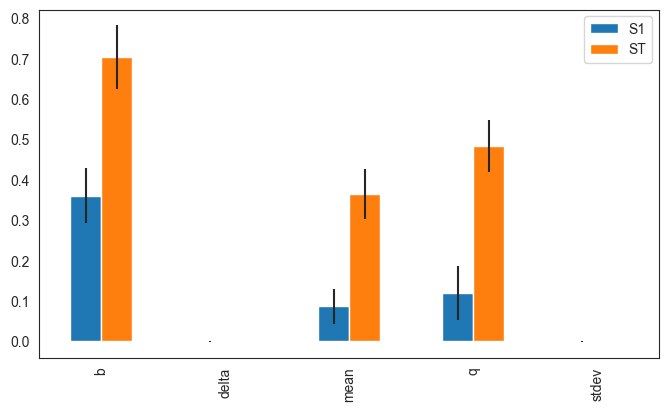

In [14]:
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [21]:
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with SequentialEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies=1,uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes["reliability"], calc_second_order=True, print_to_console=False)


100%|███████████████████████████████████| 12000/12000 [00:58<00:00, 204.31it/s]


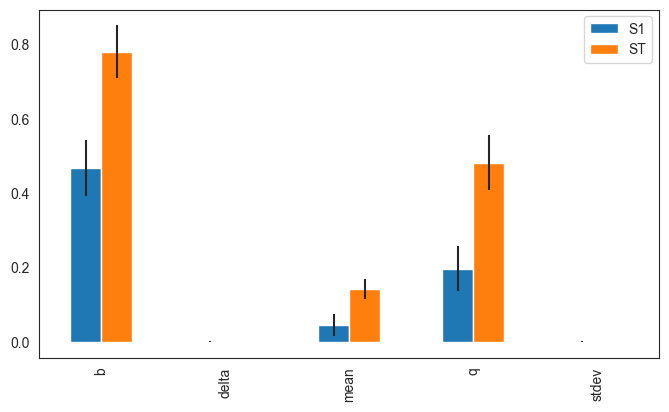

In [22]:
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

## 2. Feature scoring
Repeat the above analysis for the 3 release policies but now with extra trees [feature scoring](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results. See also the [features scoring](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#feature-scoring) section of the tutorial.*
